In [1]:
# Imports
import pandas as pd

**1) Find out which of the 80.000 cases in the training data are fraudulent cases, by mapping the file
“fraud_cases.csv” to the training data. How many fraud cases can you find?**

In [2]:
fraud_cases = pd.read_csv("fraud_cases.csv")
print(fraud_cases.columns.values)

training_data = pd.read_csv("FRISS_ClaimHistory_training.csv")
print(training_data.columns.values)

['ClaimID' 'Date_Occurred']
['sys_sector' 'sys_label' 'sys_process' 'sys_product'
 'sys_dataspecification_version' 'sys_claimid' 'sys_currency_code'
 'claim_amount_claimed_total' 'claim_causetype' 'claim_date_occurred'
 'claim_date_reported' 'claim_location_urban_area' 'object_make'
 'object_year_construction' 'ph_firstname' 'ph_gender' 'ph_name'
 'policy_fleet_flag' 'policy_insured_amount' 'policy_profitability']


At this point I found that the `sys_claimid` field is formatted in a different way than `ClaimID`, but I assume they stem from the same id. I will create a new column to perform an inner join.

In [3]:
training_data["ClaimID"] = training_data["sys_claimid"].str.extract(r"MTR-([0-9]*)-02")

# Check that all sys_claimID conform to the regex: extract returns NaN when regex does not match
assert training_data["ClaimID"].isna().sum() == 0

fraud_cases_in_training_data = pd.merge(fraud_cases,
                                        training_data,
                                        left_on="ClaimID",
                                        right_on="ClaimID")
len(fraud_cases_in_training_data)

615

The inner join returns 615 records, which means 615 fraud cases in the training data.

**The customer wants to know when the number of days between the occurrence of the claim and the report
date of the claim is high. Based on this information, an indicator at FRISS can be made. Explain what you
think is a high number, based on the training data.**

In [4]:
claim_date_format = "%Y%m%d"
claim_occurred_time = pd.to_datetime(training_data["claim_date_occurred"], format=claim_date_format)
claim_reported_time = pd.to_datetime(training_data["claim_date_reported"], format=claim_date_format)
# Check that every claim occured before report (Speaking of fraud indicators...)
assert (claim_occurred_time > claim_reported_time).sum() == 0
occured_reported_delta = claim_reported_time - claim_occurred_time

count                         80000
mean        20 days 00:39:17.640000
std      72 days 03:32:52.443470215
min                 0 days 00:00:00
25%                 2 days 00:00:00
50%                 4 days 00:00:00
75%                14 days 00:00:00
max              2778 days 00:00:00
dtype: object
76 days 00:00:00


<AxesSubplot:>

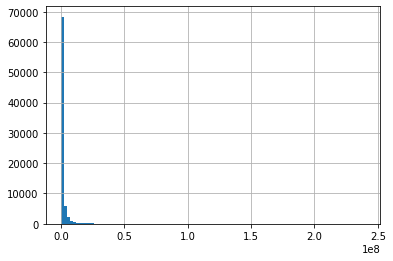

In [5]:
print(occured_reported_delta.describe())
print(occured_reported_delta.quantile(0.95))
occured_reported_delta.astype('timedelta64[s]').hist(bins=100)

To determine what "late" is I've looked at the distribution of the time between a claim being reported and when it occurred. If we plot the data it is extremely skewed towards some outlier.

Looking at the p95 percentile (95% of reports were made faster than 72 days) I decide that this is a good norm for a "high" amount of days. It is explainable and corresponds to a bit over two months, which feels reasonable. Another benefit is that this is easy to re-calculate on future data and not affected by the magnitude of extreme outliers like the mean and the standard deviation are.

**3) Clean the data by removing irrelevant features, cleaning up features and by engineering any fun new
feature that you might think of.**

First I drop the columns that are non-informative because they all have the same value are or generated by some system. I keep ClaimID so I can add the fraud labels later

In [6]:
def drop_noise_columns(training_data):
    return training_data.drop(columns=['sys_sector', 'sys_product', 'sys_label', 'sys_process', 'sys_product', 'sys_currency_code', 'sys_dataspecification_version', 'sys_claimid'])

training_data_cleaned = drop_noise_columns(training_data)

Next I remove the gender and name features. These features should not be used in a model because they come with ethical and legal issues.

In [7]:
def drop_sensitive_columns(training_data):
    return training_data.drop(columns=['ph_gender', 'ph_name', 'ph_firstname'])

training_data_cleaned = drop_sensitive_columns(training_data_cleaned)

Next we need to clean up various features to make them continous or categorical.
I add a feature that was discussed in Question two, and also a categorical feature describing the season, because some seasons(winter) are more accident prone. I choose seasons over months to reduce the amount of variables.

Some features may continous in the domain (policy profitability), but since I cannot validate this assumption I keep it categorical for now.

In [8]:
def process_categoricals(training_data):
    claim_reported_time = pd.to_datetime(training_data["claim_date_reported"], format=claim_date_format)
    claim_occurred_time = pd.to_datetime(training_data["claim_date_occurred"], format=claim_date_format)
    training_data["report_time_delta"] = (claim_reported_time - claim_occurred_time).dt.total_seconds()
    training_data["occurred_date_season"] = pd.DatetimeIndex(claim_occurred_time).month // 4
    categoricals = ["occurred_date_season", "claim_causetype", "claim_location_urban_area", "object_make", "policy_fleet_flag", "policy_profitability"]
    for column in categoricals:
        training_data = training_data.join(
            pd.get_dummies(training_data[column].astype("category"), prefix=column),
            rsuffix="_"
        )
    return training_data.drop(columns=categoricals)

training_data_cleaned = process_categoricals(training_data_cleaned)

There are 30000 NaNs in the policy_claim column, but none have 0. I assume that NaN means the object was not insured at all and thus I can set the insured amount to 0. If I worked at FRISS I would ask a domain expert

In [9]:
def make_vehicle_age_feature(training_data):
    claim_occurred_time = pd.to_datetime(training_data["claim_date_occurred"], format=claim_date_format)
    training_data["vehicle_age_years"] = pd.DatetimeIndex(claim_occurred_time).year - training_data["object_year_construction"]
    return training_data

training_data_cleaned = make_vehicle_age_feature(training_data_cleaned)

Finally I adjust the vehicle make year to represent the age of the vehicle when the claim occurred.

In [10]:
(training_data_cleaned["vehicle_age_years"] < 0).sum()

4582

Which immediately reveals that 4582 claims were made before their vehicle was made. This feels like an error in the data as this number is considerably larger than the amount of fraud cases.

Next we drop the columns which we have proccessed but are not suitable for training a model and merge with the fraud cases to obtain a dataset for training.

In [11]:
def final_cleanup(training_data):
    training_data["policy_insured_amount"].fillna(0, inplace=True)
    return training_data.drop(columns=["claim_date_occurred", "claim_date_reported", "object_year_construction"])

training_data_cleaned = final_cleanup(training_data_cleaned)

In [12]:
def make_training_labels(training_data):
    training_data_labels = fraud_cases.drop(columns=["Date_Occurred"])
    training_data_labels["fraud"] = True
    training_data_labeled = training_data.join(training_data_labels.set_index("ClaimID"), on="ClaimID")
    training_data_labeled["fraud"].fillna(False, inplace=True)
    return training_data_labeled.drop(columns=["ClaimID"])

training_data_labeled = make_training_labels(training_data_cleaned)


# Assert number of fraud cases is 615 and that no records were added; the above code is a little hacky so we need to test.
assert training_data_labeled["fraud"].sum() == 615
assert len(training_data_labeled) == 80000

In [13]:
def process_features(training_data):
    training_data_cleaned = drop_noise_columns(training_data)
    training_data_cleaned = drop_sensitive_columns(training_data_cleaned)
    training_data_cleaned = process_categoricals(training_data_cleaned)
    training_data_cleaned = make_vehicle_age_feature(training_data_cleaned)
    training_data_cleaned = final_cleanup(training_data_cleaned)
    return training_data_cleaned

**4) Train a model based on the training data and the responding fraud cases. Choose any model you like (and
Google anything you like!). Keep in mind that the data is very imbalanced and keep in mind that you should
be able to explain your model to anyone!**

First I try a logistic regression model. They are a good fit for binary classification problems, and because of their probability output we can play with the threshold to get the desired amount of true positives vs missed cases.

The model can only do a linear combination so the results are very explainable, but the models power is limited.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

labels = training_data_labeled["fraud"]
data = training_data_labeled.drop(columns=["fraud"])

In [15]:
clf = LogisticRegression(random_state=0,
                         class_weight="balanced"
                        ).fit(data.to_numpy(), labels)
predictions = clf.predict_proba(data.to_numpy())
predictions

array([[0.4368004 , 0.5631996 ],
       [0.42405016, 0.57594984],
       [0.47280869, 0.52719131],
       ...,
       [0.49176983, 0.50823017],
       [0.45720976, 0.54279024],
       [0.48541963, 0.51458037]])

In [16]:
test_set = pd.read_csv("FRISS_ClaimHistory_test.csv")
test_set_with_features = process_features(test_set)

clf.score(test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])

0.196

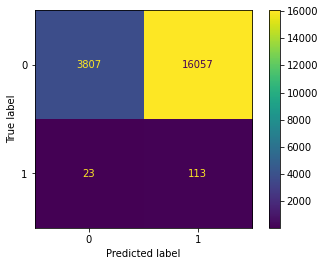

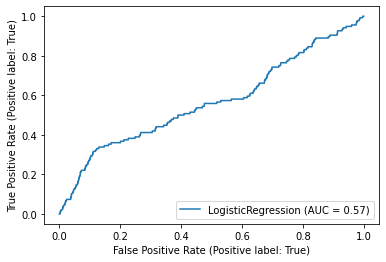

In [17]:
plot_confusion_matrix(clf, test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])
plot_roc_curve(clf, test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])

Logistic regression is a poor fit for this problem. A AUC of 0.57 is not much better than random guessing. Let's try a decision tree.

In [18]:
from sklearn.tree import DecisionTreeClassifier

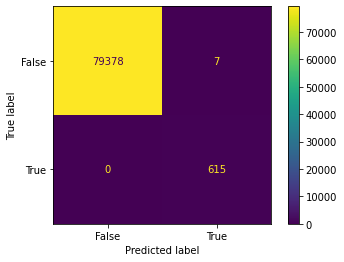

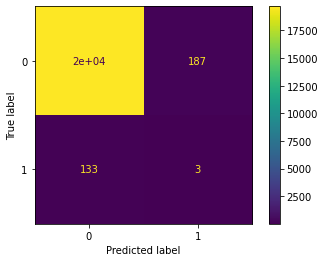

In [19]:
dtc = DecisionTreeClassifier(random_state=0,
                             class_weight="balanced"
                            ).fit(data.to_numpy(), labels)
plot_confusion_matrix(dtc, data.to_numpy(), labels)
plot_confusion_matrix(dtc, test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])

This is better, although it's very biased towards Not fraud. Let's see if we can tune it a bit, it seems to have overfit on the training data.

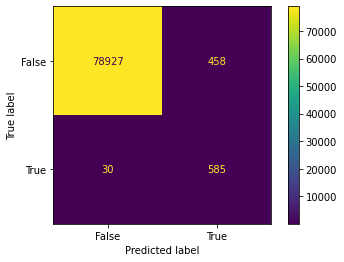

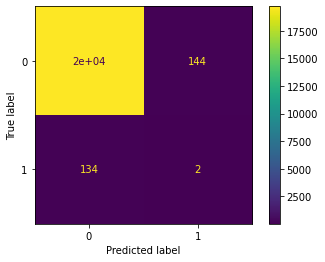

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0,
                             class_weight="balanced_subsample",
                             max_depth=15,
                             max_features=29
                            ).fit(data.to_numpy(), labels)
plot_confusion_matrix(rfc, data.to_numpy(), labels)
plot_confusion_matrix(rfc, test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])

In [ ]:
import autosklearn.classification
from autosklearn.metrics import make_scorer, recall
from sklearn.model_selection import StratifiedShuffleSplit

scorer = make_scorer('recall', recall)
automl = autosklearn.classification.AutoSklearnClassifier(
    include_estimators=["random_forest", ], exclude_estimators=None,
    include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None,
    ensemble_size=1,
    resampling_strategy=StratifiedShuffleSplit,
    metric=scorer,
    time_left_for_this_task=1800
)
automl.fit(data.to_numpy(), labels)
acs = automl.refit(data.to_numpy(), labels)

[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 233 not found
[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 42 not found

[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 421 not found
[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 634 not found[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 301 not found
[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 370 not found
[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 673 not found
[WARNING] [2021-07-02 20:05:18,578:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 263 not found
[WARNING] [2021-0

[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 524 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 698 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 334 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 61 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 585 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 459 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 567 not found
[WARNING] [2021-07-02 20:05:18,580:Client-AutoMLSMBO(1)::0dfd562c-db60-11eb-a6f0-9cb6d08d71fb] Configuration 210 not found
[WARNING] [2021-0

In [ ]:
plot_confusion_matrix(acs, data.to_numpy(), labels)
plot_confusion_matrix(acs, test_set_with_features.drop(columns=["sys_fraud"]), test_set_with_features["sys_fraud"])